In [1]:
import numpy
import autograd.numpy as np
np.set_printoptions(precision=4)
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from autograd import grad
from scipy.optimize import minimize
import time
import math
import cvxpy as cp
from matplotlib.colors import LogNorm
from numpy import linalg as LA
from scipy.stats import gmean
import cvxopt as cvx
import picos

# D-optimal design problem

\begin{align}
\min_{\theta}\quad & L(\theta):=-\ln\det \left(\sum_{i=1}^{n}\theta_iu_iu_i^{\top}\right), \\
\text{s.t.} \quad & \sum_{i=1}^{n}\theta_i=1\quad \text{and}\quad \theta_i\geq0,\quad i\in[n].
\end{align}

This note shows how to solve this problem using four different methods: 
- AEPG (Adaptive Preconditioned Gradient with Energy), 
- Interior Point method, 
- Frank-Wolfe method
- Frank-Wolfe away method.

In [2]:
def D_optimal_func(x):
    # x is an numpy array of dimension n
    V = np.dot(Q*x, Q.T)
    f = -np.log(np.linalg.det(V))
    
    H = np.linalg.inv(V)
    df =  - np.sum(Q * np.dot(H, Q), axis=0)
    return f, df

def mvee(x):
    # x is the solution to the D-optimal design problem
    m = Q.shape[0]
    X = np.diag(x).astype(float)
    M = np.dot(np.dot(Q,X),np.transpose(Q))
    H = np.linalg.inv(M)
    return np.linalg.det(M)**(-1/2)*math.pi**(m/2)/math.gamma(m/2 + 1)

In [3]:
def ngd(x, r, func, p):
    eta = p['eta']
    f, df = func(x)
    
    #_A = inv_A(Hf,B,x)
    _A = np.diag(x) - np.outer(x,x)
    ndf = _A.dot(df)
    _x = x - eta*ndf
        
    _f, _df = func(_x)
    return _f, _x, r

def aeng(x, r, func, p):
    # H is a function of x
    # B is a constant matrix
    eta = p['eta']
    c = p['c']
    
    f, df = func(x)
    dg = df / (2*np.sqrt(f+c))
    
    #_A = inv_A(Hf,B,x)
    _A = np.diag(x) - np.outer(x,x)
    ndg = _A.dot(dg)
    _r = r / (1+2*eta*ndg*ndg)
    _x = x - 2 * eta * _r * ndg
        
    _f, _df = func(_x)
    return _f, _x, _r

In [4]:
def runner(x0, func, minf, optim, p):
    start_time = time.time()

    x = np.copy(x0)
    r = np.sqrt(func(x0)[0]+p['c']) * np.ones_like(x0) 
    res = dict(fs=[func(x0)[0]], ts=[0])
    fs, ts = res['fs'], res['ts']
    
    #print('[{:4}], f: {:.4e}, x:{}'.format(0, fs[-1], 1, xs[-1]))
    
    for k in range(p['maxiter']):
        f, x, r = optim(x, r, func, p)
        t = time.time() - start_time
        
        fs.append(f)
        ts.append(t)
        
        if abs(fs[-1]-minf) < p['tol']:
            break

        if p['verbose'] and k % p['gap'] == 0:
            print('[{:4}], f: {:.4e}, t:{:.4f}'.format(k, f, t))
    
    if p['verbose']:
        print('------------------')
        print('iterations: {}'.format(k-1))
        print('solution time: {:.4f}s'.format(t))
        print('current function value: {}'.format(fs[-1]))
    #print('current parameter value: {}'.format(xs[-1]))
        
    return res

The code below for implementing the FW methods to solve the D-optimal design problems is based on this [github repository](https://github.com/microsoft/accbpg). 

For details on applying the FW method to solve the D-optimal design problem, we refer the readers to the book [Conditional Gradient Methods](https://arxiv.org/pdf/2211.14103.pdf) Chapter 5.2.7.

In [5]:
def D_opt_FW(V, x0, minf, eps, maxitrs, verbose=True, verbskip=1):
    """
    Solve the D-optimal design problem by the Frank-Wolfe algorithm
        minimize     - log(det(V*diag(x)*V'))
        subject to   x >= 0  and sum_i x_i=1
    where V is m by n matrix and x belongs to n-dimensional simplex
    Inputs:
        V:  matrix of size m by n with m < n
        x0: initial point
        eps: precision for optimality conditions (complementary slackness)
        maxitrs: maximum number of iterations
        verbose:  display computational progress (True or False)
        verbskip: number of iterations to skip between displays
    Returns (x, F, SP, SN, T):
        x:  the last iterate of BPG
        F:  array storing F(x[k]) for all k
        SP: positive slackness
        SN: negative slackness
        T:  array storing time used up to iteration k
    """
    start_time = time.time()
    
    m, n = V.shape
    F = np.zeros(maxitrs)
    T = np.zeros(maxitrs)

    x = np.copy(x0)
    VXVT = np.dot(V*x, V.T)
    detVXVT = np.linalg.det(VXVT)
    H = np.linalg.inv(VXVT)

    # compute w = - gradient # This step cost m^2*n
    w = np.sum(V * np.dot(H, V), axis=0)

    for k in range(maxitrs):
        F[k] = - np.log(detVXVT)
        T[k] = time.time() - start_time

        # compute w = - gradient # This step cost m^2*n
        # w = np.sum(V * np.dot(H, V), axis=0)
        
        # check approximate optimality conditions        
        i = np.argmax(w)

        if verbose and k % verbskip == 0:
            print('[{:4}]  f:{:.4e}  t:{:.4f}'.format(k, F[k], T[k]))
        
        if abs(F[k]-minf) < eps:
            break
            
        t = (w[i] / m - 1) / (w[i] - 1)
        x *= (1 - t)
        x[i] += t  
                
        HVi = np.dot(H, V[:,i])
        H = (H - (t / (1 + t * (w[i] - 1))) * np.outer(HVi, HVi)) / (1 - t)
        detVXVT *= np.power(1 - t, m - 1) * (1 + t * (w[i] - 1)) 
        # compute w more efficiently # This step cost m*n
        w = (w - (t / (1 + t * (w[i] - 1))) * np.dot(HVi, V)**2 ) / (1 - t)
   
    F = F[0:k+1]
    T = T[0:k+1]
    
    res = dict(fs=F, ts=T)
    
    if verbose:
        print('------------------')
        print('iterations: {}'.format(k-1))
        print('solution time: {:.4f}s'.format(T[-1]))
        print('current function value: {}'.format(F[-1]))
    return res

In [6]:
def D_opt_FW_away(V, x0, minf, eps, maxitrs, verbose=True, verbskip=1):
    """
    Solve the D-optimal design problem by Frank-Wolfe (Wolfe-Atwood) algorithm
        minimize     - log(det(V*diag(x)*V'))
        subject to   x >= 0  and sum_i x_i=1
    where V is m by n matrix and x belongs to n-dimensional simplex.
    
    This is equivalent to the Frank-Wolfe algorithm with Away steps.
    Inputs:
        V:  matrix of size m by n with m < n
        x0: initial point
        eps: precision for optimality conditions (complementary slackness)
        maxitrs: maximum number of iterations
        verbose:  display computational progress (True or False)
        verbskip: number of iterations to skip between displays
    Returns (x, F, SP, SN, T):
        x:  the last iterate of BPG
        F:  array storing F(x[k]) for all k
        SP: positive slackness
        SN: negative slackness
        T:  array storing time used up to iteration k
    """
    start_time = time.time()

    m, n = V.shape
    F = np.zeros(maxitrs)
    SP = np.zeros(maxitrs)
    SN = np.zeros(maxitrs)
    T = np.zeros(maxitrs)

    x = np.copy(x0)
    VXVT = np.dot(V*x, V.T)
    detVXVT = np.linalg.det(VXVT)
    H = np.linalg.inv(VXVT)

    # compute w = - gradient # This step cost m^2*n
    w = np.sum(V * np.dot(H, V), axis=0)

    if verbose:
        print("\nSolving D-opt design problem using Frank-Wolfe method with away steps")
        print("     k      F(x)     pos_slack   neg_slack    time")
        
    for k in range(maxitrs):
        F[k] = np.log(np.linalg.det(H))
        # the following can be much faster but often inaccurate!
        #F[k] = - np.log(detVXVT)
        T[k] = time.time() - start_time

        # compute w = - gradient # This step cost m^2*n
        #w = np.sum(V * np.dot(H, V), axis=0)

        # check approximate optimality conditions        
        i = np.argmax(w)
        ww = w - w[i]   # shift the array so that ww.max() = 0
        j = np.argmin(ww * [x > 1.0e-8])
        #j = np.argmin(ww * [x > 0])

        eps_pos = w[i] / m - 1
        eps_neg = 1 - w[j] / m
        SP[k] = eps_pos
        SN[k] = eps_neg
   
        if verbose and k % verbskip == 0:
            print("{0:6d}  {1:10.4e}  {2:10.3e}  {3:10.3e}  {4:6.1f}".format(
                    k, F[k], eps_pos, eps_neg, T[k]))

        #if eps_pos <= eps and eps_neg <= eps:
        #    break
        
        if abs(F[k]-minf) < eps:
            break
            
        if eps_pos >= eps_neg:
            t = (w[i] / m - 1) / (w[i] - 1)
            x *= (1 - t)
            x[i] += t
            HVi = np.dot(H, V[:,i])
            H = (H - (t / (1 - t + t * w[i])) * np.outer(HVi, HVi)) / (1 - t)
            detVXVT *= np.power(1 - t, m - 1) * (1 + t * (w[i] - 1)) 
            # compute w more efficiently # This step cost m*n
            w = (w - (t / (1 - t + t * w[i])) * np.dot(HVi, V)**2 ) / (1 - t)
        else: # Wolfe's awaystep
            t = min((1 - w[j] / m) / (w[j] - 1), x[j] / (1 - x[j]))
            x *= (1 + t)
            x[j] -= t
            HVj = np.dot(H, V[:,j])
            H = (H + (t / (1 + t - t * w[j])) * np.outer(HVj, HVj)) / (1 + t)
            detVXVT *= np.power(1 + t, m - 1) * (1 + t - t * w[i]) 
            # compute w more efficiently # This step cost m*n
            w = (w + (t / (1 + t - t * w[j])) * np.dot(HVj, V)**2 ) / (1 + t)

    F = F[0:k+1]
    SP = SP[0:k+1]
    SN = SN[0:k+1]
    T = T[0:k+1]
    
    res = dict(fs=F, ts=T)
    
    if verbose:
        print('------------------')
        print('iterations: {}'.format(k-1))
        print('solution time: {:.4f}s'.format(T[-1]))
        print('current function value: {}'.format(F[-1]))
        
    return res

# Generate dataset

In [72]:
n, m = 1000, 300   # n test vectors of dimension m
x0 = 1/n*np.ones(n) # initial point

## 1. Generate new dataset

In [57]:
mean = np.zeros(m)
cov = np.identity(m)
B_D = np.ones((1,n))
Q = np.random.multivariate_normal(mean,cov,n).T  # shape of Q is (m, n)

## 2. Load data used to obtain reults in the paper

In [73]:
dd = np.load('Doptimal/D_n{}_m{}.npy'.format(n, m), allow_pickle=True)
Q = dd.item()['args']['Q']

## For m = 10, 30, 50, 80, 100, solve by PICOS

The state of the art method for solving optimal design problems with arbitrary linear constraints was the MAXDET formulation of Vandenberghe, Boyd and Wu [42], which is in fact reformulated as an SDP (Semidefinite Programming) by PICOS:

\begin{align}
\max_{t\in\mathbb{R}, \theta\in\mathbb{R}^n}\quad & t\\
\text{s.t.} \quad &  \sum_{i=1}^{n}\theta_i \leq 1,\quad\text{and}\quad \det\left(\sum_{i=1}^{n}\theta_iu_iu^\top_i\right)^{1/m} \geq t.
\end{align}

Then this SDP problem is solve by interior point method through solver [CVXOPT](https://cvxopt.org/documentation/index.html).

We refer the reader to the [example section of the PICOS documentation](https://picos-api.gitlab.io/picos/optdes.html#optdes-refs) for detailed implementation.

In [82]:
D_MAXDET = picos.Problem()

U = []
for i in range(n):
    Ui = np.outer(Q[:,i], Q[:,i])
    U.append(cvx.matrix(Ui))

UU = [picos.Constant('V[{0}]'.format(i), Ui) for i, Ui in enumerate(U)]
w = picos.RealVariable('w', n, lower=0)
t = picos.RealVariable('t', 1)

wgt_cons = D_MAXDET.add_constraint(1|w <= 1)
Mw = picos.sum([w[i] * UU[i] for i in range(n)])
detrootn_cons = D_MAXDET.add_constraint(t <= picos.DetRootN(Mw))
D_MAXDET.set_objective('max', t)

In [ ]:
# For m = 10, run this cell
solution = D_MAXDET.solve(solver='cvxopt', verbosity=1, 
                          abs_bnb_opt_tol     = 1e-04,
                          abs_dual_fsb_tol    = 1e-04,
                          abs_ipm_opt_tol     = 1e-05,
                          abs_prim_fsb_tol    = 1e-05,
                          rel_dual_fsb_tol    = 1e-05,
                          rel_ipm_opt_tol     = 1e-05,
                          rel_prim_fsb_tol    = 1e-05)

In [83]:
# For m = 30, 50, 80, 100, run this cell
solution = D_MAXDET.solve(solver='cvxopt', verbosity=1, 
                          abs_bnb_opt_tol     = 1e-04,
                          abs_dual_fsb_tol    = 1e-05,
                          abs_ipm_opt_tol     = 1e-06,
                          abs_prim_fsb_tol    = 1e-05,
                          rel_dual_fsb_tol    = 1e-05,
                          rel_ipm_opt_tol     = 1e-06,
                          rel_prim_fsb_tol    = 1e-05)

           PICOS 2.4.17            
Problem type: Optimization Problem.
Searching a solution strategy for CVXOPT.
Solution strategy:
  1. ExtraOptions
  2. DetRootNReformulation
  3. GeometricMeanToRSOCReformulation
  4. CVXOPTSolver
Applying ExtraOptions.
Applying DetRootNReformulation.
Applying GeometricMeanToRSOCReformulation.
Building a CVXOPT problem instance.
Starting solution search.
-----------------------------------
 Python Convex Optimization Solver 
    via internal CONELP solver     
-----------------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.3333e+00  1e+03  3e+01  1e+03  1e+00
 1: -1.1839e-01 -4.6637e-01  8e+01  5e+00  2e+02  4e-03
 2: -1.3062e-02 -9.3728e-02  1e+01  1e+00  5e+01  2e-02
 3: -5.2827e-02 -7.9967e-02  7e+00  6e-01  2e+01  1e-02
 4: -3.1840e-01 -3.4083e-01  9e+00  5e-01  2e+01  1e-02
 5: -7.3210e-01 -7.4355e-01  7e+00  3e-01  1e+01  1e-02
 6: -9.5535e-01 -9.6476e-01  5e+00  2e-01  9e+00  6e-03
 7: -1.1534e+00 

In [84]:
minf = D_optimal_func(np.array(w))[0]
minf

-8.683862625093788

## For m = 200, 300, 400, 500, solve by CVXPY

In [58]:
x = cp.Variable(n)
obj = cp.Minimize(-cp.log_det(Q @ cp.diag(x) @ Q.T))
cst = [cp.sum(x) == 1, x>=0]
prob = cp.Problem(obj, cst)
prob.solve()

17.72332313037945

In [59]:
minf = prob.value

## Frank-Wolfe (FW) 

In [79]:
fw = D_opt_FW(Q, x0, minf, eps=1e-7, maxitrs=50000, verbose=True, verbskip=10000)

[   0]  f:5.0255e+01  t:0.0125
[10000]  f:4.7918e+01  t:3.2354
[20000]  f:4.7873e+01  t:6.2868
[30000]  f:4.7854e+01  t:9.1339
[40000]  f:4.7844e+01  t:12.1457
------------------
iterations: 49998
solution time: 15.1037s
current function value: 47.83715218252195


## FW-away

In [80]:
fa = D_opt_FW_away(Q, x0, minf, eps=1e-7, maxitrs=50000, verbose=True, verbskip=1000)


Solving D-opt design problem using Frank-Wolfe method with away steps
     k      F(x)     pos_slack   neg_slack    time
     0  5.0255e+01   2.216e-01   2.171e-01     0.0
  1000  4.7808e+01   6.676e-03   6.678e-03     0.9
------------------
iterations: 1459
solution time: 1.3543s
current function value: 47.804716416199525


## AEPG

- m = 10, c = 9, eta = 0.08, tol = 1e-7
- m = 30, c = 10, eta = 0.02, tol = 1e-7
- m = 50, c = 10, eta = 0.01, tol = 1e-7
- m = 80, c = 7, eta = 0.01, tol = 1e-7
- m = 100, c = 7, eta = 0.01, tol = 1e-7
- m = 200, c = 1, eta = 0.009, tol = 1e-7
- m = 300, c = 1, eta = 0.006, tol = 1e-7
- m = 400, c = 1, eta = 0.005, tol = 1e-7
- m = 400, c = 1, eta = 0.00, tol = 1e-7

In [68]:
eta = 0.009
c = 1
eng = runner(x0, D_optimal_func, minf, aeng, 
                       p=dict(eta=eta, c=c, lambda1=1, maxiter=1000, tol=1e-7, verbose=True, gap=200))

[   0], f: 1.9583e+01, t:0.0295
[ 200], f: 1.7723e+01, t:1.7687
[ 400], f: 1.7723e+01, t:3.6638
[ 600], f: 1.7723e+01, t:5.5672
[ 800], f: 1.7723e+01, t:7.3252
------------------
iterations: 998
solution time: 9.0575s
current function value: 17.723297898320588


In [70]:
# save the dataset and prameters to repeat the results given in the paper.
# np.save('Doptimal/D_n1000_m200.npy', dict(aeng=eng, fw=fw, fa=fa, args = dict(minf=minf, Q=Q, eta=eta, c=c)))

# Load experimental results in the paper directly

In [38]:
n, m = 1000, 300   # n test vectors of dimension m
dd = np.load('Doptimal/D_n{}_m{}.npy'.format(n, m), allow_pickle=True)

In [131]:
# For m = 10, 30, 50, 80, 100, solution time of PICOS (interior point method)
# dd.item()['ipm']

In [78]:
eng = dd.item()['aeng']
fw = dd.item()['fw']
fa = dd.item()['fa']
minf = dd.item()['args']['minf']

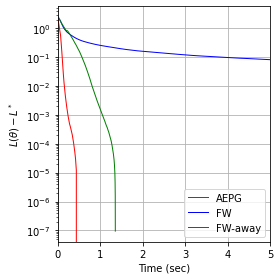

In [81]:
tt = 0
plt.figure(1, figsize=(4,4))

plt.plot(eng['ts'][tt:], eng['fs'][tt:]-minf, 'r', lw=1, label='AEPG')
plt.plot(fw['ts'][tt:], fw['fs'][tt:]-minf, 'b', lw=1, label='FW')
plt.plot(fa['ts'][tt:], fa['fs'][tt:]-minf, 'g', lw=1, label='FW-away')

plt.yscale('log')
plt.xlim([0,5])
plt.xlabel('Time (sec)')
plt.ylabel(r'$L(\theta)-L^*$')
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()

# plt.savefig('D_n1000_m200.png', dpi=300)

#### 